Reference : https://www.kaggle.com/code/puja07/auc-roc-curve-for-multi-class-classification

### Data Content
* The target feature is
    * Drug type
* The feature sets are:
    * Age
    * Sex
    * Blood Pressure Levels (BP)
    * Cholesterol Levels
    * Na to Potassium Ration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn import  metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [2]:
from imblearn.over_sampling import SMOTE

* 데이터 불러오기

In [3]:
df = pd.read_csv("drug200.csv")
df.shape

(200, 6)

In [4]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [7]:
df.describe(include="object")

,Sex,BP,Cholesterol,Drug
count,200,200,200,200
unique,2,3,2,5
top,M,HIGH,HIGH,DrugY
freq,104,77,103,91


In [8]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

### Visualization

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Na_to_K'}>]], dtype=object)

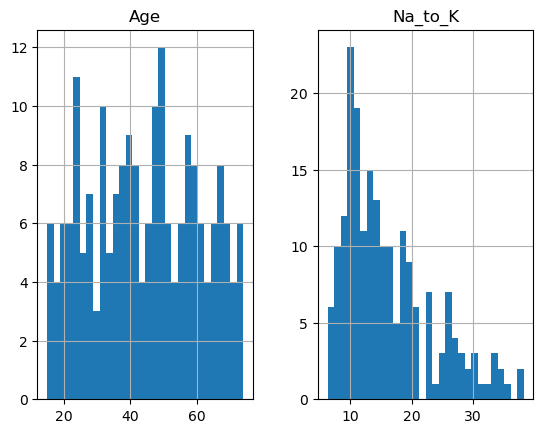

In [9]:
df.hist(bins=30)

<AxesSubplot:>

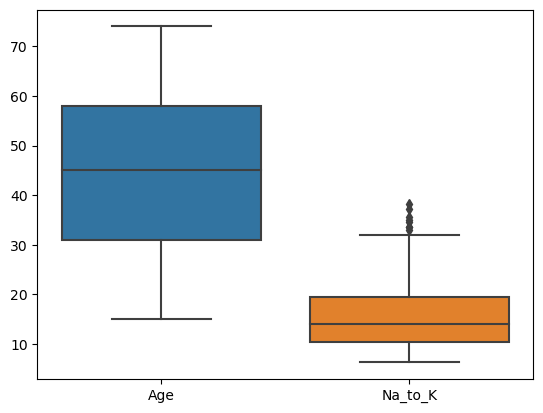

In [10]:
sns.boxplot(data=df[["Age","Na_to_K"]])

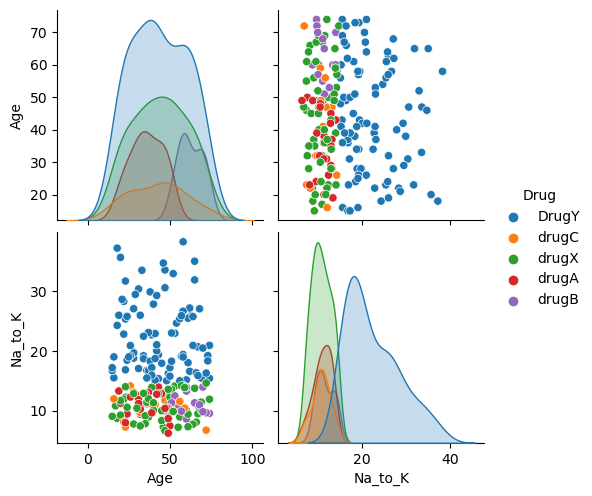

In [11]:
sns.pairplot(df, hue="Drug")

<AxesSubplot:>

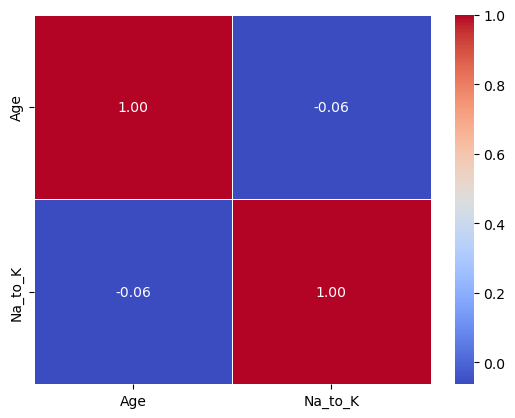

In [12]:
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f', cmap='coolwarm')

<AxesSubplot:xlabel='Drug', ylabel='count'>

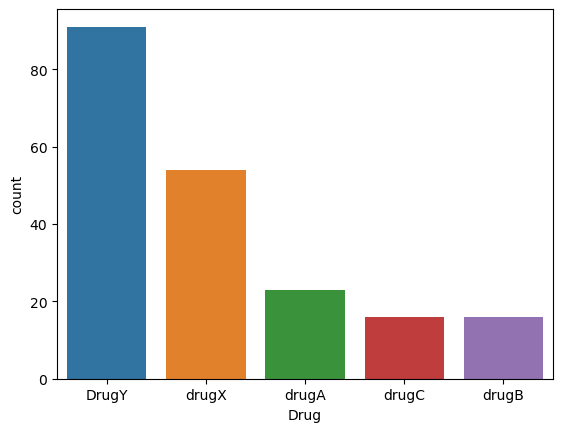

In [13]:
sns.countplot(data=df, x="Drug",order=df["Drug"].value_counts().sort_values(ascending=False).index)

In [14]:
DA_gb = df.groupby(["Drug"])["Age"].mean().to_frame().sort_values(by="Age",ascending=False)
DA_gb

,Age
Drug,
drugB,62.500000
drugX,44.018519
DrugY,43.747253
drugC,42.500000
drugA,35.869565


In [15]:
DNK_gb = df.groupby(["Drug"])["Na_to_K"].mean().to_frame().sort_values(by="Na_to_K",ascending=False)
DNK_gb

,Na_to_K
Drug,
DrugY,22.374780
drugB,11.524375
drugA,10.918783
drugX,10.650556
drugC,10.633750


<AxesSubplot:xlabel='Drug', ylabel='Na_to_K'>

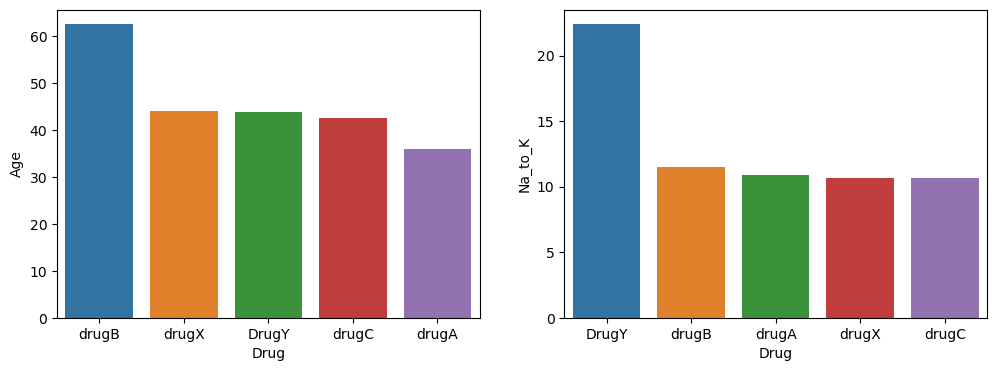

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.barplot(data=DA_gb, x=DA_gb.index, y="Age", ax=ax[0])
sns.barplot(data=DNK_gb, x=DNK_gb.index, y="Na_to_K", ax=ax[1])

### Preprocessing

* Encoding
    * Sex - one hot encoding
    * BP - label : [0, 1, 2] : ['HIGH', 'LOW', 'NORMAL']
    * Cholesterol - label : [0, 1] : ['HIGH', 'NORMAL']
    * Drug - label : [0, 1, 2, 3, 4] : ['DrugY', 'drugA', 'drugB', 'drugC', 'drugX']

In [17]:
df["Gender"] = df["Sex"] =="F"

In [18]:
df["BPL"] = le.fit(df["BP"])
df["BPL"] = le.transform(df["BP"])

In [19]:
df["Ch"] = le.fit(df["Cholesterol"])
df["Ch"] = le.transform(df["Cholesterol"])

In [20]:
df["Drug_label"] = le.fit(df["Drug"])
df["Drug_label"] = le.transform(df["Drug"])

### Modeling

* Split train and test set

In [21]:
df.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug', 'Gender', 'BPL',
       'Ch', 'Drug_label'],
      dtype='object')

In [22]:
feature_names = ['Age', 'Na_to_K', 'Gender', 'BPL','Ch']

In [23]:
label_name = "Drug_label"
label_name

'Drug_label'

* 오버샘플링으로 모델링 후 피쳐 중에서 분류에 영향이 거의 없는 gender 변수 제거 후 진행
    * 차이가 없음

In [108]:
feature_names2 = ['Age', 'Na_to_K', 'BPL','Ch']

In [109]:
label_name = "Drug_label"
label_name

'Drug_label'

In [110]:
X = df[feature_names2]
y = df[label_name]
X.shape, y.shape

((200, 4), (200,))

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [113]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 4), (40, 4), (160,), (40,))

### over sampling

In [114]:
smote = SMOTE(random_state=42)

In [115]:
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (160, 4) (160,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (365, 4) (365,)
SMOTE 적용 후 레이블 값 분포: 
 0    73
4    73
2    73
3    73
1    73
Name: Drug_label, dtype: int64


* [0, 1, 2, 3, 4] : ['DrugY', 'drugA', 'drugB', 'drugC', 'drugX']

Text(0.5, 1.0, 'test')

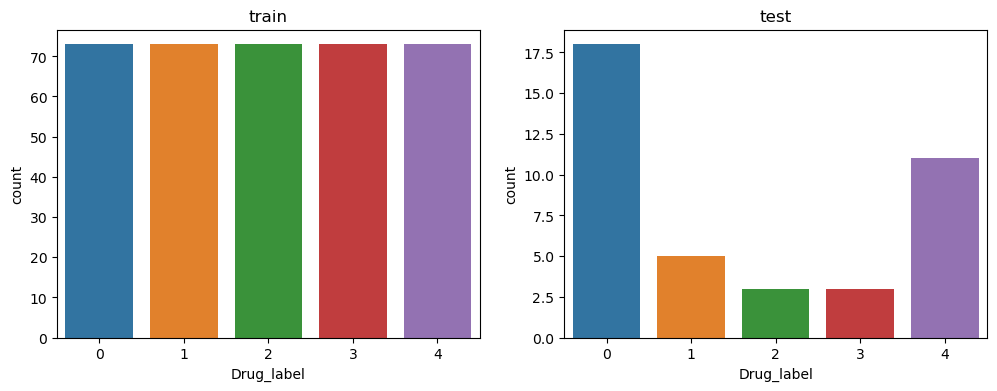

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.countplot(x=y_train_over, ax=ax[0]).set_title("train")
sns.countplot(x=y_test, ax=ax[1]).set_title("test")

In [117]:
y_train_over.value_counts(normalize=True)

0    0.2
4    0.2
2    0.2
3    0.2
1    0.2
Name: Drug_label, dtype: float64

In [118]:
y_test.value_counts(normalize=True)

0    0.450
4    0.275
1    0.125
3    0.075
2    0.075
Name: Drug_label, dtype: float64

In [119]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model

RandomForestClassifier(n_jobs=-1, random_state=42)

### Hyperparameter Tuning - RandomizedSearchCV

* 오버샘플링 이전
* 하이퍼파라미터를 다르게 해도 정확도가 변하지 않음
* RandomForestClassifier(max_depth=13, max_features=0.7452043304237215, n_jobs=-1,random_state=42)
    * 0.975
* RandomForestClassifier(max_depth=11, max_features=0.6497617129839334, n_jobs=-1,random_state=42)
    * 0.975
* RandomForestClassifier(max_depth=19, max_features=0.8829599795379455, n_jobs=-1,random_state=42)
    * 0.975

### 비교를 위해 이전과 같은 상태(8 : 2 샘플링해서 진행)
* RandomForest
* RandomForestClassifier(max_depth=10, max_features=0.7117991473796641, n_jobs=-1, random_state=42)
    * 0.97
* RandomForestClassifier(max_depth=5, max_features=0.8725994255747616, n_jobs=-1, random_state=42)
     * 0.97
* RandomForestClassifier(max_depth=5, max_features=0.9770001447242052, n_jobs=-1, random_state=42)
    * 0.97

In [120]:
param_distributions = {"n_estimators": [100],
                       "max_depth" : np.random.randint(3, 20, 10) ,
                       "max_features" : np.random.uniform(0.5, 1, 10)}
clfr = RandomizedSearchCV(model,
                          param_distributions=param_distributions,
                          n_iter=10,
                          cv=5, 
                          n_jobs=-1,
                          random_state=42, 
                          scoring="accuracy", verbose=1)
clfr.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 4,  4,  7, 11, 14, 12, 11,  7, 12,  9]),
                                        'max_features': array([0.69159041, 0.65639393, 0.79995747, 0.83424844, 0.57439099,
       0.56091668, 0.82615277, 0.97080381, 0.51220005, 0.83904737]),
                                        'n_estimators': [100]},
                   random_state=42, scoring='accuracy', verbose=1)

In [121]:
clfr.best_estimator_

RandomForestClassifier(max_depth=12, max_features=0.834248442002334, n_jobs=-1,
                       random_state=42)

In [122]:
clfr.best_params_

{'n_estimators': 100, 'max_features': 0.834248442002334, 'max_depth': 12}

In [123]:
best_model = clfr.best_estimator_.fit(X_train_over, y_train_over)
best_model.fit(X_train_over, y_train_over)

RandomForestClassifier(max_depth=12, max_features=0.834248442002334, n_jobs=-1,
                       random_state=42)

In [124]:
y_predict = best_model.predict(X_test)

### Accuracy

In [125]:
accuracy_score(y_test, y_predict)

0.975

<AxesSubplot:>

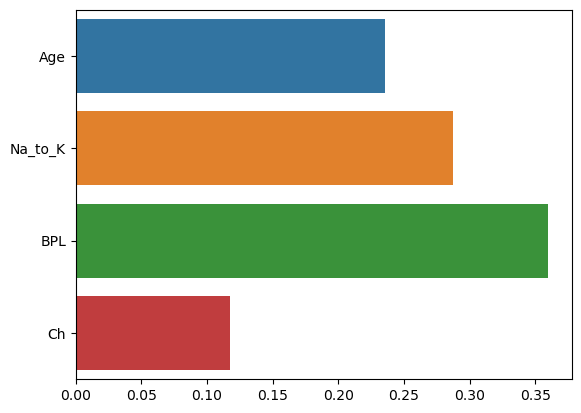

In [126]:
#feature_name2 결과
sns.barplot(x=best_model.feature_importances_, y=best_model.feature_names_in_)

In [127]:
best_model_acc = 100*best_model.score(X_test, y_test)
print('Random Forest Classifier Predictions : \n', best_model.predict(X_test), '\n Accuracy:', best_model_acc, '%')

Random Forest Classifier Predictions : 
 [0 1 0 0 4 4 4 4 3 3 0 1 0 4 1 0 0 0 4 0 0 1 0 4 0 0 0 0 1 4 0 0 0 0 2 2 4
 2 3 4] 
 Accuracy: 97.5 %


In [128]:
report = classification_report(y_test, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.91      0.95        11

    accuracy                           0.97        40
   macro avg       0.99      0.98      0.99        40
weighted avg       0.98      0.97      0.97        40



C:\Users\chae\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


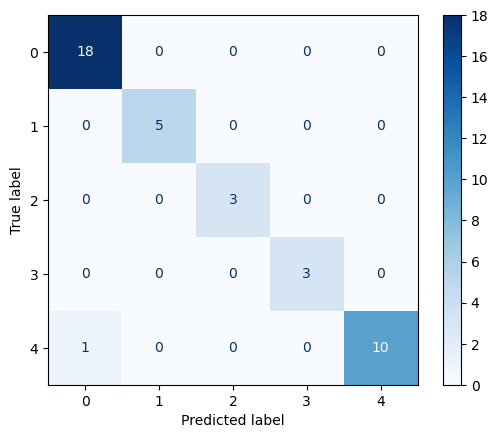

<Figure size 1500x1500 with 0 Axes>

In [89]:
plot_confusion_matrix(best_model, X_test, y_test, cmap=plt.cm.Blues)  
plt.figure(figsize = (15, 15))
plt.show()